# Load (Preprocessed) Dataset

In [1]:
from pathlib import Path
from anomalib.data.folder import Folder
from anomalib.data.task_type import TaskType
from anomalib.data.utils import TestSplitMode

# Set up for semi-supervised learning
datamodule = Folder( 
    root=Path.cwd() / "battery_discharging",
    normal_dir="normal_masked",
    image_size=(80, 60),
    test_split_mode=TestSplitMode.SYNTHETIC,
    task=TaskType.CLASSIFICATION,

)

# Split the data into train and test sets
datamodule.setup()

i, data = next(enumerate(datamodule.val_dataloader()))

print(data["image"].shape)

torch.Size([32, 3, 80, 60])


# Initialize Patchcore Model

In [3]:
from anomalib.models import Patchcore

# Configure Patchcore model
model = Patchcore(
    layers=["layer1", "layer2", "layer3"],
    backbone="resnet18",
    input_size=(80, 60)
)

# Define names here...
dataset_name = "MBatDis8020"
model_name = "patchcore"


c:\Users\PEE1UL\AppData\Local\miniconda3\envs\ganomaly\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.


# Train the Patchcore Model

In [4]:
from anomalib.post_processing import NormalizationMethod, ThresholdMethod 
from anomalib.utils.callbacks.export import ExportCallback, ExportMode
from pytorch_lightning.callbacks import ModelCheckpoint 

from anomalib.utils.callbacks import ( 
    MetricsConfigurationCallback, 
    MinMaxNormalizationCallback, 
    PostProcessingConfigurationCallback, 
) 


# Define the export path for the model
export_dir = Path.cwd() / "models" / f"{model_name}" / f"{dataset_name}"

# Make sure the export directory exists
export_dir.mkdir(parents=True, exist_ok=True)

callbacks = [ 

    MetricsConfigurationCallback( 
        task=TaskType.CLASSIFICATION, 
        image_metrics=["AUROC"], 
    ), 

    ModelCheckpoint( 
        mode="max", 
        monitor="image_AUROC", 
    ), 

    PostProcessingConfigurationCallback( 
        normalization_method=NormalizationMethod.MIN_MAX, 
        threshold_method=ThresholdMethod.ADAPTIVE, 
    ), 

    MinMaxNormalizationCallback(), 

    ExportCallback( 
        input_size=(80, 60), 
        dirpath=str(export_dir), 
        filename="model", 
        export_mode=ExportMode.TORCH, 
    ), 
]

In [7]:

from pytorch_lightning import Trainer

# Use PyTorch Lightning Trainer for training
trainer = Trainer(
   callbacks=callbacks,
    accelerator= "cpu",
    auto_scale_batch_size= False,
    check_val_every_n_epoch= 1,
    devices= 1,
    gpus= None,
    max_epochs= 1,
    num_sanity_val_steps= 0,
    val_check_interval= 1.0,
)

trainer.fit(model=model, datamodule=datamodule)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | image_threshold       | AnomalyScoreThreshold    | 0     
1 | pixel_threshold       | AnomalyScoreThreshold    | 0     
2 | model                 | PatchcoreModel           | 2.8 M 
3 | image_metrics         | AnomalibMetricCollection | 0     
4 | pixel_metrics         | AnomalibMetricCollection | 0     
5 | normalization_metrics | MinMax                   | 0     
------------------------------------------------------------------

Training: 0it [00:00, ?it/s]

c:\Users\PEE1UL\AppData\Local\miniconda3\envs\ganomaly\lib\site-packages\pytorch_lightning\loops\optimization\optimizer_loop.py:138: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")


Validation: 0it [00:00, ?it/s]

# Configure the Inferencer

In [4]:
from anomalib.deploy import TorchInferencer

# Change paths here..
torch_model_path = Path.cwd() / "models" / f"{model_name}" / f"{dataset_name}" /"weights" / "torch" / "model.pt"

inferencer = TorchInferencer(

    # Pass the config file to the inferencer in case
    path=torch_model_path, # Path to the Torch IR model. 
    device="cpu", # We would like to run it on an Intel CPU. 

)

In [5]:
import os
import matplotlib.pyplot as plt

# Function to visualize the predictions
def visualize_predictions(image, anomaly_map, score, mask, threshold=0.65, alpha=0.5, colormap='jet'):
    """
    Visualize the image, anomaly map, prediction score, and mask.
    Display 'Anomaly' in red if score exceeds the threshold, otherwise display 'Normal' in green.

    Args:
        image (np.ndarray): The input image.
        anomaly_map (np.ndarray): The anomaly map.
        score (float): The prediction score.
        mask (np.ndarray): The binary mask of the anomalies.
        threshold (float): Threshold to classify as anomaly or normal.
        alpha (float): Transparency level for the overlay.
        colormap (str): Colormap to use for the anomaly map.
    """
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Display the original image with anomaly map overlay
    axs[0].imshow(image, cmap='gray')
    anomaly_overlay = axs[0].imshow(anomaly_map, cmap=colormap, alpha=alpha)
    fig.colorbar(anomaly_overlay, ax=axs[0])
    
    # Determine the text and color based on the score
    if score > threshold:
        status_text = 'Anomaly'
        color = 'red'
    else:
        status_text = 'Normal'
        color = 'green'
    
    axs[0].set_title(f'Anomaly Map (Score: {score:.2f})\nStatus: {status_text}', color=color)
    
    # Display the mask
    axs[1].imshow(image, cmap='gray')
    axs[1].imshow(mask, cmap='Reds', alpha=alpha)
    axs[1].set_title('Anomaly Mask')
    
    # Display the original image
    axs[2].imshow(image, cmap='gray')
    axs[2].set_title('Original Image')
    
    plt.tight_layout()
    plt.show()

In [6]:
import glob
from anomalib.data.utils import read_image

# Set the path to the test image directory
test_image_directory = "./battery_discharging/test/masked/*.png"

# Get a list of all image paths in the directory
test_image_paths = glob.glob(test_image_directory)

# Create an empty list to store prediction scores
prediction_scores = []

# Iterate over each image and run the model predictions
for image_path in test_image_paths:

    #print(f"Processing image: {image_path}")  # Debugging print

    # Read the image
    image = read_image(path=image_path)
    
    # Run predictions using the inferencer
    predictions = inferencer.predict(image=image)
    
    # Extract prediction score
    score = predictions.pred_score
    
    # Append the score to the list
    prediction_scores.append(score)

    #Optional: Extract prediction results
    image = predictions.image
    anomaly_map = predictions.anomaly_map
    score = predictions.pred_score
    mask = predictions.pred_mask
    
    #Visualize the predictions
    #visualize_predictions(image, anomaly_map, score, mask)

# Print the collected prediction scores as an array
print("Prediction Scores Array:", prediction_scores)

# Count how many scores are above the defined threshold
count_above_threshold = sum(score > 0.80 for score in prediction_scores)

# Print the total count
print(f"Number of prediction scores above 0.80: {count_above_threshold}")

Prediction Scores Array: [1.0, 1.0, 1.0, 0.8054032921791077, 1.0, 0.8392486572265625, 0.9820723533630371, 0.8509055376052856, 1.0, 0.8360118865966797, 1.0, 1.0, 0.750126838684082, 1.0, 1.0, 0.9948469996452332, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9604079723358154, 1.0, 0.9359908103942871, 1.0, 1.0, 1.0, 1.0, 0.9535014629364014, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9529107809066772, 0.9359908103942871, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9625403881072998, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9024689197540283, 1.0, 0.9075037837028503, 0.9931799173355103, 0.9030279517173767, 1.0, 0.8671696186065674, 0.8368118405342102, 0.8954635262489319, 0.9675104022026062, 0.8540533781051636, 0.8956528902053833, 1.0, 1.0, 1.0, 0.7798845767974854, 1.0, 0.7657207250595093, 0.7804597020149231, 1.0, 0.879004955291748, 0.8572723865509033, 1.0, 1.0, 1.0, 0.7964885234832764, 0.8133898973464966, 1.0, 0.9675104022026062, 0.854053378

# Calculate Evaluation Metrics

AUC-ROC: 0.9997952162516383
Precision: 0.9911504424778761
Recall: 1.0


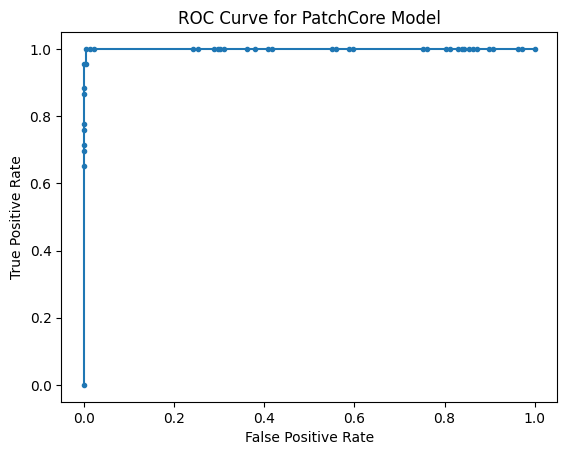

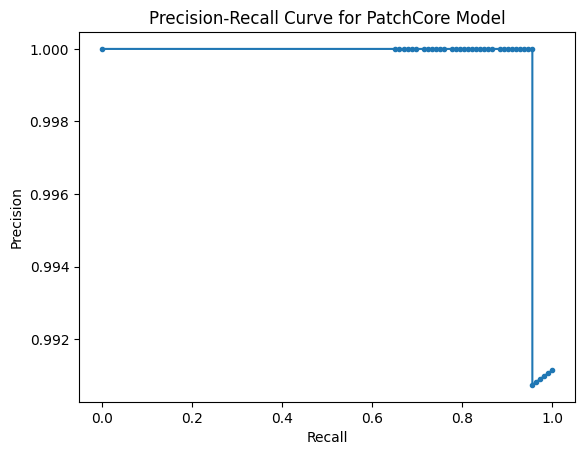

In [ ]:
# Import necessary modules
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, precision_score, recall_score

# Create a new array of 0s and 1s
y_test = [1 if os.path.basename(path).startswith("a_") else 0 for path in test_image_paths]

# Define the threshold value
threshold = 0.75

# Calculate AUC-ROC (negate scores because lower scores indicate anomalies)
auc = roc_auc_score(y_test, prediction_scores)  # Use prediction_scores to reflect anomaly likelihood
print(f"AUC-ROC: {auc}")

# Calculate precision and recall metrics
precision_value = precision_score(y_test, [1 if score >= threshold else 0 for score in prediction_scores])
recall_value = recall_score(y_test, [1 if score >= threshold else 0 for score in prediction_scores])
print(f"Precision: {precision_value}")
print(f"Recall: {recall_value}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, prediction_scores)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for PatchCore Model')
plt.show()

# Measure Latency

In [ ]:
import glob
import time
from anomalib.data.utils import read_image


# Get a list of all image paths in the directory
test_image_paths = glob.glob(test_image_directory)


# Create an empty list to store prediction scores and inference times
prediction_scores = []
inference_times = []

# Iterate over each image and run the model predictions
for image_path in test_image_paths:
    #print(f"Processing image: {image_path}")  # Debugging print

    # Read the image
    image = read_image(path=image_path)
    
    # Measure the inference start time
    start_time = time.time()
    
    # Run predictions using the inferencer
    predictions = inferencer.predict(image=image)
    
    # Measure the inference end time
    end_time = time.time()
    
    # Calculate the inference time and add to the list
    inference_time = end_time - start_time
    inference_times.append(inference_time)
    
    # Extract prediction score
    score = predictions.pred_score
    
    # Append the score to the list
    prediction_scores.append(score)

    

# Calculate and print the mean inference time for the all images
mean_inference_time = (sum(inference_times) / len(inference_times)) * 1000 #convert to ms
print(f"Mean Inference Time for all images: {mean_inference_time:.4f} ms")

Mean Inference Time for all images: 54.0609 ms
